Experimental notebook to explore use of SymPy for NMR simulations. Currently unfit for human consumption.

Note: [SymPsi](http://sympsi.github.io) looked promising, but hasn't been updated since 2015. 

Concept: can Hamiltonians be calculated once, symbolically, and then used and reused with supplied frequency/coupling variables? Can their eigensolution? 

If so, this could dramatically speed up calculations.

Note: apparently, it is not possible to get all eigenvalues for a scipy sparse matrix. A complete eigensolution is required by the simulation.

In [1]:
import numpy as np
from sympy import *

In [2]:
# For nice-looking output:
init_printing()

For reference, the original Hamiltonian code that we will try to improve upon:

In [3]:
def hamiltonian(freqlist, couplings):
    """
    Computes the spin Hamiltonian for spin-1/2 nuclei.
    inputs for n nuclei:
        :param freqlist: a list of frequencies in Hz of length n
        :param couplings: an n x n array of coupling constants in Hz
    Returns: a Hamiltonian array
    """
    nspins = len(freqlist)

    # Define Pauli matrices
    sigma_x = np.matrix([[0, 1 / 2], [1 / 2, 0]])
    sigma_y = np.matrix([[0, -1j / 2], [1j / 2, 0]])
    sigma_z = np.matrix([[1 / 2, 0], [0, -1 / 2]])
    unit = np.matrix([[1, 0], [0, 1]])

    # The following empty arrays will be used to store the
    # Cartesian spin operators.
    Lx = np.empty((1, nspins), dtype='object')
    Ly = np.empty((1, nspins), dtype='object')
    Lz = np.empty((1, nspins), dtype='object')

    for n in range(nspins):
        Lx[0, n] = 1
        Ly[0, n] = 1
        Lz[0, n] = 1
        for k in range(nspins):
            if k == n:                                  # Diagonal element
                Lx[0, n] = np.kron(Lx[0, n], sigma_x)
                Ly[0, n] = np.kron(Ly[0, n], sigma_y)
                Lz[0, n] = np.kron(Lz[0, n], sigma_z)
            else:                                       # Off-diagonal element
                Lx[0, n] = np.kron(Lx[0, n], unit)
                Ly[0, n] = np.kron(Ly[0, n], unit)
                Lz[0, n] = np.kron(Lz[0, n], unit)

    Lcol = np.vstack((Lx, Ly, Lz)).real
    Lrow = Lcol.T  # As opposed to sparse version of code, this works!
    Lproduct = np.dot(Lrow, Lcol)

    # Hamiltonian operator
    H = np.zeros((2**nspins, 2**nspins))

    # Add Zeeman interactions:
    for n in range(nspins):
        H = H + freqlist[n] * Lz[0, n]

    # Scalar couplings

    # Testing with MATLAB discovered J must be /2.
    # Believe it is related to the fact that in the SpinDynamics.org simulation
    # freqs are *2pi, but Js by pi only.
    scalars = 0.5 * couplings
    scalars = np.multiply(scalars, Lproduct)
    for n in range(nspins):
        for k in range(nspins):
            H += scalars[n, k].real

    return H



Default frequencies and couplings from WINDNMR for 8-spin system:



In [4]:
def spin8():
    v = np.array([85, 120, 160, 185, 205, 215, 235, 260])
    J = np.zeros((8, 8))
    J[0, 1] = -12
    J[0, 2] = 6
    J[0, 3] = 2
    # J[0, 4] = 0
    # J[0, 5] = 0
    # J[0, 6] = 0
    # J[0, 7] = 0
    # J[1, 2] = 0
    # J[1, 3] = 0
    J[1, 4] = 14
    # J[1, 5] = 0
    # J[1, 6] = 0
    J[1, 7] = 3
    # J[2, 3] = 0
    # J[2, 4] = 0
    J[2, 5] = 3
    # J[2, 6] = 0
    # J[2, 7] = 0
    # J[3, 4] = 0
    J[3, 5] = 5
    # J[3, 6] = 0
    # J[3, 7] = 0
    J[4, 5] = 2
    # J[4, 6] = 0
    # J[4, 7] = 0
    # J[5, 6] = 0
    # J[5, 7] = 0
    J[6, 7] = 12
    J = J + J.T
    return v, J

and for 2:



In [5]:
def spin2():
    v = np.array([150-7.5, 150+7.5])
    J = np.zeros((2, 2))
    J[0, 1] = 12
    J = J + J.T
    return v, J

In [6]:
# Test that old hamiltonian produces expected result:
v, J = spin2()
h = hamiltonian(v, J)
h

matrix([[ 153. ,    0. ,    0. ,    0. ],
        [   0. ,  -10.5,    6. ,    0. ],
        [   0. ,    6. ,    4.5,    0. ],
        [   0. ,    0. ,    0. , -147. ]])

In [7]:
E, V = np.linalg.eigh(h)
print(E)
V

[-147.          -12.60468636    6.60468636  153.        ]


matrix([[ 0.        ,  0.        , -0.        ,  1.        ],
        [ 0.        , -0.94362832, -0.33100694,  0.        ],
        [ 0.        ,  0.33100694, -0.94362832,  0.        ],
        [ 1.        ,  0.        , -0.        ,  0.        ]])

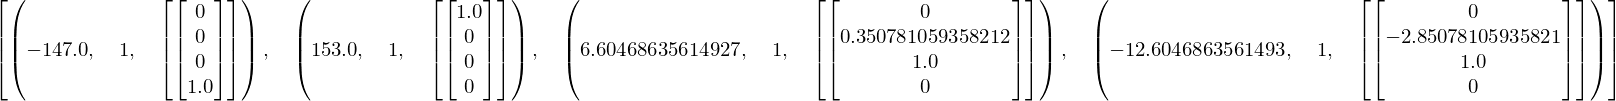

In [8]:
# can sympy get all eigenvalues for a sparse matrix? scipy can't.
# the answer appears to be that it can!
h = SparseMatrix(4, 4, {
    (0, 0): 153, 
    (3,3):-147, 
    (1, 1): -10.5, 
    (2,2):4.5,
    (1,2):6,(2,1):6})
h.eigenvects()

Now, will try to replicate hamiltonian using SymPy.

In [9]:
sigma_x = MatrixSymbol('sigma_x', 2, 2)
sigma_y = MatrixSymbol('sigma_y', 2, 2)
sigma_z = MatrixSymbol('sigma_z', 2, 2)
unit = MatrixSymbol('I', 2, 2)  # careful--SymPy uses I for i
sigma_x, sigma_y, sigma_z, unit

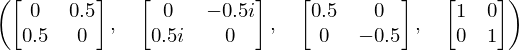

In [10]:
# Define Pauli matrices
sigma_x = Matrix([[0, 1 / 2], [1 / 2, 0]])
sigma_y = Matrix([[0, -1j / 2], [1j / 2, 0]])
sigma_z = Matrix([[1 / 2, 0], [0, -1 / 2]])
unit = Matrix([[1, 0], [0, 1]])
sigma_x, sigma_y, sigma_z, unit
    

In [11]:
v1, v2 = symbols("v1, v2")
v1 + v2

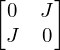

In [12]:
J = Symbol('J')
j_matrix = Matrix([[0, J], [J, 0]])
j_matrix

In [13]:
from sympy.physics.quantum import TensorProduct
from sympy.tensor.array import MutableDenseNDimArray as MArray

Issues to resolve/work around:
Can an array of matrices be constructed for Lx, Ly, Lz as before?
TensorProduct, unlike np.kron, won't accept an integer, so tensor product between 1 and $\sigma_{x/y/z}$/I not possible.

Create a kron function to make this possible:

In [14]:
def kron(m1, m2):
    """Compute a Kronecker product of m1 and m2 if m1 is a matrix, 
    or scalar multiplication of m2 if m1 is a scalar.
    """
    try:
        prod = TensorProduct(m1, m2)
    except AttributeError:
        try:
            prod = m1 * m2
        except:
            prod = None
    return prod

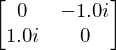

In [15]:
kron(2, sigma_y)

In [17]:
# When sympy mutable arrays were tried, saving a Matrix as an MArray element
# gave a 'not implemented' error. The sympy code suggested MArray elements
# could not be certain iterable types.
Lx = MArray([1] * 4)
Ly = MArray([1] * 4)
Lz = MArray([1] * 4)

Lx, Ly, Lz

In [18]:
TensorProduct(1, sigma_y)

AttributeError: ImmutableDenseMatrix has no attribute args_cnc.

In [19]:
nspins = 2
for n in range(nspins):
        for k in range(nspins):
            if k == n:                                  # Diagonal element
                Lx[n] = kron(Lx[n], sigma_x)
                Ly[n] = TensorProduct(Ly[n], sigma_y)
                Lz[n] = TensorProduct(Lz[n], sigma_z)
            else:                                       # Off-diagonal element
                Lx[n] = TensorProduct(Lx[n], unit)
                Ly[n] = TensorProduct(Ly[n], unit)
                Lz[n] = TensorProduct(Lz[n], unit)
Lx, Ly, Lz

NotImplementedError: 